### Домашнее задание к лекции 4 

1. Прочитайте базу my_PJME_MW.csv и сделайте ее перерасчет (ресемплинг) в представление по неделям.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd 
import seaborn as sns
import statsmodels.api as sm


from sklearn.metrics import mean_squared_error
import os

import warnings

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression 
from sklearn.feature_selection import SelectKBest, SelectPercentile
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score



from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV

from sklearn.feature_selection import f_regression, mutual_info_regression

import seaborn as sns

from sklearn.decomposition import PCA
import scipy.stats as scs



from heapq import merge
import pickle

In [2]:
Path_Energy = 'my_PJME_MW.csv'
data = pd.read_csv(Path_Energy, index_col=[0], parse_dates=[0])
data.head()

,Time,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,dayofweek,hour,is_holiday,is_prev_holiday,is_next_holiday
Date,,,,,,,,,,,,,
2002-01-01,01:00:00,30393.0,2002,1,1,1,1,1,1,1,1,0,0
2002-01-01,02:00:00,29265.0,2002,1,1,1,1,1,1,2,1,0,0
2002-01-01,03:00:00,28357.0,2002,1,1,1,1,1,1,3,1,0,0
2002-01-01,04:00:00,27899.0,2002,1,1,1,1,1,1,4,1,0,0
2002-01-01,05:00:00,28057.0,2002,1,1,1,1,1,1,5,1,0,0


In [3]:
data_w = data.copy().resample('W').mean()
# удалим признаки dayofweek, hour, is_holiday,is_prev_holiday, is_next_holiday как неактуальные для недельного ресемплинга
non_actual_features = ['dayofweek', 'hour', 'is_holiday','is_prev_holiday', 'is_next_holiday']
data_w.drop(non_actual_features, axis=1,inplace=True)
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear
Date,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0


In [4]:
# пропуски есть?
data_w.loc[data_w['PJME_MW'].isna() == 1 ,:].head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear
Date,,,,,,,


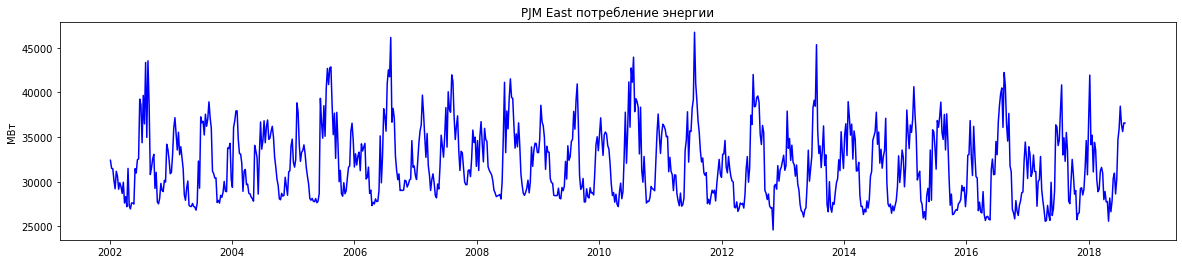

In [5]:
plt.figure(figsize =(20,4))
plt.plot(data_w['PJME_MW'], 'b' )
plt.title('PJM East потребление энергии' )
plt.ylabel ( 'МВт' )
plt.show()

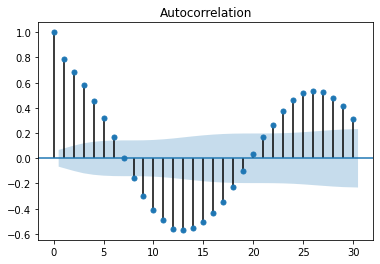

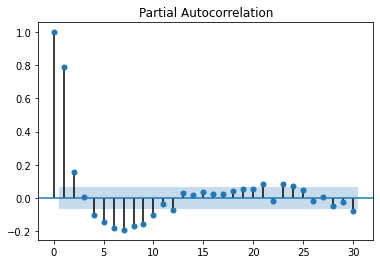

In [6]:
sm.graphics.tsa.plot_acf(data_w['PJME_MW'].values, lags=30)
plt.show()

sm.graphics.tsa.plot_pacf(data_w['PJME_MW'].values, lags=30)
plt.show()

Первая картинка говорит что есть сезоны и что есть автокорреляция - генерируем всякие новые признаки t1, t2, ... t13...

Вторая картинка говорит что в частичной автокорреляци первые разности будут хорошо работать - генерируем новый признак с первыми разностями

2. Постройте модель предсказания 4-й точки от текущей (h = 4), используя результаты автокорреляционного анализа из предшествующих уроков .

In [7]:
# Строимм интегральные признаки используя кластер-анализ или частичную классификацию. 
# Воспользуемся методом DBSCAN, который не требует знания реального числа кластеров.

scl=StandardScaler()
tsne_ =TSNE(n_components=2)
pca_ =PCA(n_components=2)

X = data_w.iloc[:,:].values

Xscale = scl.fit_transform(X)
X_t = tsne_.fit_transform(Xscale)
X_p = pca_.fit_transform(Xscale)

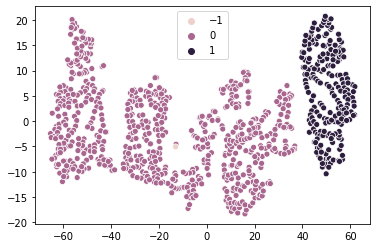

In [8]:
clast_0 = DBSCAN(eps=5, leaf_size=15 )
clast_1 = DBSCAN(eps=2, leaf_size=5)
X_clast =clast_0.fit_predict(X_t)
X_scale_clast =clast_1.fit_predict(Xscale)

sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_clast)
plt.show()

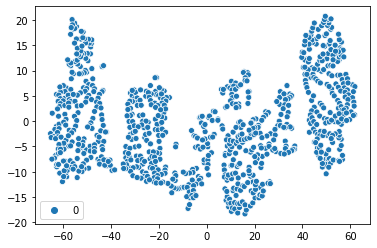

In [9]:
sns.scatterplot(X_t[:,0],X_t[:,1], hue=X_scale_clast )
plt.show()

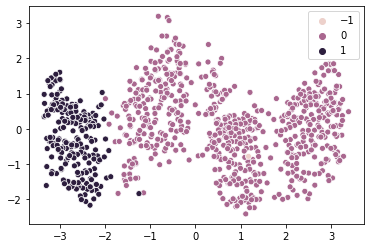

In [10]:
sns.scatterplot(X_p[:,0],X_p[:,1], hue=X_clast)
plt.show()

Рис.3. Результат кластер-анализа признаков

In [11]:
print('Число кластеров в календаре с масштабированием: ',len(np.unique(X_scale_clast)))
print('Число кластеров в календаре: ',len(np.unique(X_clast)))

Число кластеров в календаре с масштабированием:  1
Число кластеров в календаре:  3


Вариант кластеризации с разметкой на рис.3 для случая масштабированных координат показывает отлично выделяемые кластеры с хорошим размещением объектов по группам. Принадлежность кластерам можно использовать в качестве нового признака и проверить качество обработки модели с новой координатой. В данном конкретном примере кластеризация без масштабирования, но с понижением размерности выглядит очень обосновано. Берем этот вариант за основу и добавим признак к общему описанию задачи. 

In [12]:
data_w['day_week_month'] = X_clast
data_w.iloc[np.where(data_w['day_week_month']==0)[0]]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,day_week_month
Date,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,0
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,0
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,0
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,0
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,0
...,...,...,...,...,...,...,...,...
2018-07-08,38459.982143,2018.0,7.000000,5.000000,3.0,186.000000,27.0,0
2018-07-15,36420.035714,2018.0,7.000000,12.000000,3.0,193.000000,28.0,0
2018-07-22,35612.095238,2018.0,7.000000,19.000000,3.0,200.000000,29.0,0


В выборке объектов типа 0 собраны недели с 1го по 3й кварталы, а в типе 1 нового признака собрали недели из 4го квартала:).

In [13]:
data_w.iloc[np.where(data_w['day_week_month']==1)[0]]

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,day_week_month
Date,,,,,,,,
2002-10-06,31042.369048,2002.0,9.857143,7.285714,3.857143,276.000000,40.0,1
2002-10-13,27714.601190,2002.0,10.000000,10.000000,4.000000,283.000000,41.0,1
2002-10-20,27504.827381,2002.0,10.000000,17.000000,4.000000,290.000000,42.0,1
2002-10-27,28137.335329,2002.0,10.000000,23.982036,4.000000,296.982036,43.0,1
2002-11-03,29799.845238,2002.0,10.428571,17.714286,4.000000,304.000000,44.0,1
...,...,...,...,...,...,...,...,...
2017-12-03,29121.220238,2017.0,11.428571,17.142857,4.000000,334.000000,48.0,1
2017-12-10,31447.303571,2017.0,12.000000,7.000000,4.000000,341.000000,49.0,1
2017-12-17,34607.303571,2017.0,12.000000,14.000000,4.000000,348.000000,50.0,1


Другой путь получения новых признаков применение преобразований для понижения размерности. Пример такого преобразования приведен выще в процессе построения признака из кластерного анализа , использовали редукцию пространства с использованием модели t-SNE. Однако, эта модель характерна высокой вычислительной сложностью, что увеличивает время решения задачи. Более простая, хотя и линейная модель, это PCA - метод главных компонент. Поскольку наши координаты календаря вполне связаны, то можно проверить и такой путь объединения признаков. Добавим признак на основе компонетного анализа. Построим 2 компоненты по признакам из календаря , без значений ряда и допишем их в общую таблицу data_w.

In [14]:
pca = PCA(n_components=2, svd_solver='full')
Xpca=pca.fit_transform(Xscale[:,1:-1])
Xpca.shape

(866, 2)

In [15]:
data_w['pca1']=Xpca[:,0]
data_w['pca2']=Xpca[:,1]

Добавим новых признаков, описывающих содержание ряда. К таким признакам можно отнести разности ряда и разнообразные варианты сглаживания. Добавим к нашей модели 1-е разности. При этом следует помнить, что такие операции уменьшают общую длину корректной выборки на 1, т.е. первую строку данных следует исключить из модели в момент обучения.

In [16]:
first_diff =np.array(data_w.iloc[1:,0].values - data_w.iloc[:-1,0].values).astype('float32') 
data_w['diff1'] = 0.0
data_w['diff1'] =  data_w['diff1'].astype('float') 
data_w['diff1'].values[1:] = first_diff

Вообще можно добавить все, что можем придумать. Например, логарифм признака, частные признаков , частные логарифмов и т.д. 

In [17]:
first_diff_w =(first_diff) / data_w.iloc[1:,0].values
data_w['diff1_w'] = 0.0
data_w['diff1_w'] =  data_w['diff1_w'].astype('float') 
data_w['diff1_w'].values[1:] = np.array(first_diff_w).astype('float32')

Можно, например, взять Бокс-Кокс преобразование (тут не работает, т.к. дисперсия постоянна - нет смысла)

In [18]:
def invboxcox(y,lmbda):
    # обрабтное преобразование Бокса-Кокса
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

In [19]:
first_diff_l =np.log(data_w.iloc[1:,0].values) 
#first_diff_l, lmbda1 = scs.boxcox(data_d.iloc[1:,0].values) # НЕ РАБОТАЕТ , когда АРГУМЕНТ ЛОГАРИФМА БЛИЗОК 0 
data_w['diff1_l'] = 0
data_w['diff1_l'] =  data_w['diff1_l'].astype('float') 
data_w['diff1_l'].values[1:] = first_diff_l

Добавим скользящее среднее по всей модели с глубиной 4 недели. Размер окна определен длиной месячных циклов.

In [20]:
data_w['d_w7']=data_w['PJME_MW'].rolling(window=4).mean()

А теперь добавим еще и экспонентциальную среднюю. Медленную, т.к. интересная информация лежит на уровне сезонных колебаний цены.

In [21]:
def exponential_smoothing(series, alpha):
    result = [series[0]] 
    for n in range(1, len(series)):
        result.append(alpha * series[n] + (1 - alpha) * result[n-1])
    return result

data_w['exp_0_05'] = exponential_smoothing(data_w['PJME_MW'], 0.05)


In [22]:
data_w.head()

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,day_week_month,pca1,pca2,diff1,diff1_w,diff1_l,d_w7,exp_0_05
Date,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,0,-2.695287,2.368119,0.000000,0.000000,0.000000,NaN,32392.160839
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,0,-2.628017,1.567724,-904.773926,-0.028734,10.357342,NaN,32346.922142
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,0,-2.555377,0.703435,-34.505951,-0.001097,10.356246,NaN,32302.220083
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,0,-2.482738,-0.160854,-1311.351196,-0.043506,10.313659,31368.489615,32194.185567
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,0,-2.400129,0.614172,-945.041687,-0.032368,10.281804,30569.571429,32044.300693


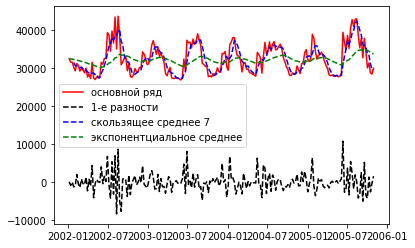

In [23]:
N100=200
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд')
plt.plot(data_w.index[:N100],data_w['diff1'][:N100],'--k',label ='1-е разности')
plt.plot(data_w.index[:N100],data_w['d_w7'][:N100],'--b',label ='скользящее среднее 7')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--g',label ='экспонентциальное среднее')
plt.legend()
plt.show()


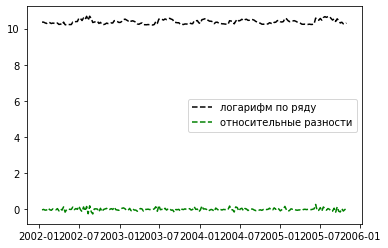

In [24]:
N100=200
plt.plot(data_w.index[1:N100],data_w['diff1_l'][1:N100],'--k',label ='логарифм по ряду')

plt.plot(data_w.index[1:N100],data_w['diff1_w'][1:N100],'--g',label ='относительные разности')
plt.legend()
plt.show()

Проблема состоит в том, что подобных признаков можно построить бесконечное количество. Для определения разумных интервалов имеет смысл вспомнить результаты анализа ряда в статистических моделях. Период сезонных колебаний 52 недель и месячный цикл по неделям. Это позволит не строить все возможные сочетания параметров модели, а сократить их число до относительно небольшого подмножества. Посмотрим на примере экспоненциальных средних в диапазоне alpha = [0.3, 0.8] 

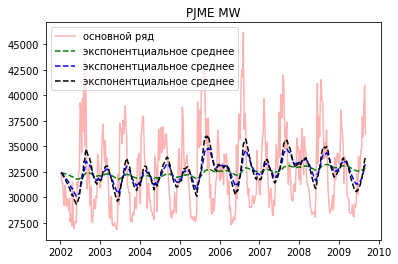

In [25]:
data_w['exp_0_01'] = exponential_smoothing(data_w['PJME_MW'], 0.01)
data_w['exp_0_03'] = exponential_smoothing(data_w['PJME_MW'], 0.03)
data_w['exp_0_04'] = exponential_smoothing(data_w['PJME_MW'], 0.04)
data_w['exp_0_06'] = exponential_smoothing(data_w['PJME_MW'], 0.06)
data_w['exp_0_07'] = exponential_smoothing(data_w['PJME_MW'], 0.07)
data_w['exp_0_08'] = exponential_smoothing(data_w['PJME_MW'], 0.08)

N100=400
plt.plot(data_w.index[:N100],data_w['PJME_MW'][:N100],'r',label ='основной ряд',alpha=0.3)
plt.plot(data_w.index[:N100],data_w['exp_0_01'][:N100],'--g',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_05'][:N100],'--b',label ='экспонентциальное среднее')
plt.plot(data_w.index[:N100],data_w['exp_0_08'][:N100],'--k',label ='экспонентциальное среднее')
plt.legend()
plt.title('PJME MW')
plt.show()

In [26]:
data_w.iloc[:7,14]=0

Добавим истории длиной p в признаках автокорреляции

In [27]:
p = 14
for i in range(p):
    data_w['t'+str(p-i)]=0
    data_w['t'+str(p-i)].values[p:] = data_w['PJME_MW'].values[i:-(p)+i]

Аналогично добавляем первые разности на глубину p

In [28]:
p = 14
for i in range(p):
    data_w['d'+str(p-i)]=0
    data_w['d'+str(p-i)].values[p:] = data_w['diff1'].values[i:-(p)+i]

Итоговая система признаков

In [29]:
data_w.head(20)

,PJME_MW,year,month,dayofmonth,quarter,dayofyear,weekofyear,day_week_month,pca1,pca2,...,d10,d9,d8,d7,d6,d5,d4,d3,d2,d1
Date,,,,,,,,,,,,,,,,,,,,,
2002-01-06,32392.160839,2002.0,1.000000,3.517483,1.0,3.517483,1.0,0,-2.695287,2.368119,...,0,0,0,0,0,0,0,0,0,0
2002-01-13,31487.386905,2002.0,1.000000,10.000000,1.0,10.000000,2.0,0,-2.628017,1.567724,...,0,0,0,0,0,0,0,0,0,0
2002-01-20,31452.880952,2002.0,1.000000,17.000000,1.0,17.000000,3.0,0,-2.555377,0.703435,...,0,0,0,0,0,0,0,0,0,0
2002-01-27,30141.529762,2002.0,1.000000,24.000000,1.0,24.000000,4.0,0,-2.482738,-0.160854,...,0,0,0,0,0,0,0,0,0,0
2002-02-03,29196.488095,2002.0,1.428571,17.714286,1.0,31.000000,5.0,0,-2.400129,0.614172,...,0,0,0,0,0,0,0,0,0,0
2002-02-10,31150.517857,2002.0,2.000000,7.000000,1.0,38.000000,6.0,0,-2.314197,1.935636,...,0,0,0,0,0,0,0,0,0,0
2002-02-17,30616.565476,2002.0,2.000000,14.000000,1.0,45.000000,7.0,0,-2.241558,1.071347,...,0,0,0,0,0,0,0,0,0,0
2002-02-24,29144.130952,2002.0,2.000000,21.000000,1.0,52.000000,8.0,0,-2.168918,0.207058,...,0,0,0,0,0,0,0,0,0,0
2002-03-03,29869.011905,2002.0,2.428571,16.000000,1.0,59.000000,9.0,0,-2.080177,0.823732,...,0,0,0,0,0,0,0,0,0,0


In [63]:
def data_prepare(data, target, h, p):
     #Запишем итоговую систему признаков и проведем ее анализ. Горизонт прогнозирования h = 1, тогда target = y(t+h)=y(t+1)
    scl_target=StandardScaler() 
    scl_x=StandardScaler() 
    # тут мы сдвигаем y влево на h
    target = data['PJME_MW'].values[p+h:].reshape((data.shape[0]-h-p,1))
    y = scl_target.fit_transform(target)
    # выравниваем X справа для равенства размеров X и y
    X = data.iloc[p:-h,:].values
    X = scl_x.fit_transform(X.astype('float64'))
    
    print(f'Проверяем равенство размеров - Х: {X.shape}, размер y: {y.shape}')
      
    #Применим автоматизацию выбора через SelectKBest c выделением 7 лучших признаков.
    sfk = SelectKBest(f_regression, k=7)
    X_new1 = sfk.fit_transform(X, y.ravel())
#     print(f'Размер таблицы после выделения лучших признаков по SelectKBest {X_new1.shape}')
    column_names = list(data.columns[sfk.get_support()])
    print(f'Лучшие признаки по SelectKBest: {column_names}')
    
    # Проверим результат оценки признаков по процентному отбору и сохраним его в X_new2.
    
    sfp=SelectPercentile(f_regression, percentile=20)
    X_new2 = sfp.fit_transform(X, y.ravel())
    #print(f'Размер таблицы после выделения лучших признаков по процентному отбору {X_new2.shape}')
    column_names = list(data.columns[sfp.get_support()])
    print(f'Лучшие признаки по процентному отбору: {column_names}')
    
    # Проверим результат оценки признаков по GradientBoostingRegressor и построим новое пространство в X_new3
    
    gr_model = GradientBoostingRegressor(max_depth=5, n_estimators=10).fit(X, y.ravel())
    sfm = SelectFromModel(gr_model,  max_features = 7)
    sfm.fit(X, y.ravel())
    X_new3 = sfm.transform(X)
    #print(f'Размер таблицы после выделения лучших признаков по GradientBoostingRegressor {X_new3.shape}')
    column_names = list(data.columns[sfm.get_support()])
    print(f'Лучшие признаки по GradientBoostingRegressor: {column_names}')
    
    list_param_k =np.where(sfk.get_support())[0]
    list_param_p =np.where(sfp.get_support())[0]
    list_param_m =np.where(sfm.get_support())[0]
    
    # Пересечение выбора по отбору для модели и по количественным оценкам связи в признаке 0. Имеет смысл брать объединение выборов.
    list_par=list(set(merge(list_param_k, list_param_p, list_param_m)))
    X_new = X[:,list_par]
    print(f'Список лучших параметров: {list_par}')
    
    return X_new, X, y, scl_x, scl_target, list_par

In [31]:
# функция разделения данных на трейн и тест
def split_data( data, split_date ):
    return data.loc[data.index.get_level_values('Date') <= split_date].copy(), \
           data.loc[data.index.get_level_values('Date') >  split_date].copy()

In [32]:
# функция расчета MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [51]:
# функция построения и оценки модели
def model(data, target, title, split_date, X_new, X, y, scl_x, scl_target, n_iter_search, h, p):
    # Разделение данных на тестовые и тренировочные
    train, test = split_data( data, split_date)
    # строим график
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel('Время')
    plt.ylabel(title)
    plt.plot(train.index.get_level_values('Date'),train[target], label='train data' )
    plt.plot(test.index.get_level_values('Date'),test[target], label='test data')
    plt.title( 'Тестовые и тренировочные данные' )
    plt.legend()
    plt.show()
    
    # формируем признаки и таргет на трейне и на тесте
    X_train =X_new[:train.shape[0],:]
    y_train =y[:train.shape[0],0]
    X_test =X_new[train.shape[0]:,:]
    y_test =y[train.shape[0]:,0]
    
    # выясняем лучшие параметры
    param_dist = {"max_depth": [3, 2,10,14,5], 
              "n_estimators":[100,200,300,400,500, 1000, 1200,1500]}

    n_iter_search = 10

    model_gr =GradientBoostingRegressor()

    random_search = RandomizedSearchCV(model_gr, param_distributions=param_dist, n_iter=n_iter_search, cv=5, iid=False)

    random_search.fit(X_train, y_train)

    print(f'Лучшие параметры: {random_search.best_params_}')
    print(f'Лучшая точность при данных параметрах: {random_search.best_score_}')
    
    # строим лучшую модель
    model_g_best = GradientBoostingRegressor(max_depth=random_search.best_params_.get('max_depth'),  
                                             n_estimators=random_search.best_params_.get('n_estimators'))
    model_g_best.fit( X_train, y_train ) 
    y_test_pred_g = model_g_best.predict(X_test)
    
    #смотрим метрики
    er_s = mean_squared_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_a = mean_absolute_error(y_true=y_test, y_pred=y_test_pred_g) 
    er_r2 = r2_score(y_true=y_test, y_pred=y_test_pred_g)

    print('ошибка mse :  ', er_s,'\nошибка mae  :  ', er_a,'\nоценка R2 :  ', er_r2)

    er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test),y_pred = scl_target.inverse_transform( y_test_pred_g))
    print('ошибка градиентного бустинга MAPE :  ', er_g,'%')
    
    # рисуем график предикта и реальный
    plt.figure( figsize=( 15, 7 ))
    plt.xlabel('Время')
    plt.ylabel(title)
    plt.plot(test.index[h+p:],y_test_pred_g, label='predict GB data' )
    plt.plot(test.index[h+p:],y_test, label='test data')
    plt.legend()
    plt.show()
    
    # исследуем график корреляций
    lag=10
    p_cor=[np.corrcoef( y_test, y_test_pred_g)[1,0]]
    for i in range(lag):
        c=np.corrcoef( y_test[:-(i+1)], y_test_pred_g[(i+1):])[1,0]
        p_cor.append(c)    

    plt.plot(np.array(p_cor) )  
    plt.xlabel('лаг корреляции')
    plt.ylabel('cor_coeff')
    plt.title('корреляция с целью для предсказаний с лагом просмотра')
    plt.show()
    
    #сохранение модели
    filename = 'final_model.sav'
    pickle.dump(model_g_best, open(filename, 'wb'))

    filename = 'final_scaler_y.sav'
    pickle.dump(scl_target, open(filename, 'wb'))

    filename = 'final_scaler_x.sav'
    pickle.dump(scl_x, open(filename, 'wb'))
    
    return X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g


Проверяем равенство размеров - Х: (848, 49), размер y: (848, 1)
Лучшие признаки по SelectKBest: ['PJME_MW', 'diff1_l', 't11', 't10', 't9', 't8', 't7']
Лучшие признаки по процентному отбору: ['PJME_MW', 'diff1_l', 't13', 't12', 't11', 't10', 't9', 't8', 't7', 't6']
Лучшие признаки по GradientBoostingRegressor: ['year', 'dayofyear', 'pca1', 'diff1_l', 'exp_0_03', 't9', 't8']
Список лучших параметров: [0, 1, 5, 8, 12, 16, 22, 23, 24, 25, 26, 27, 28, 29]


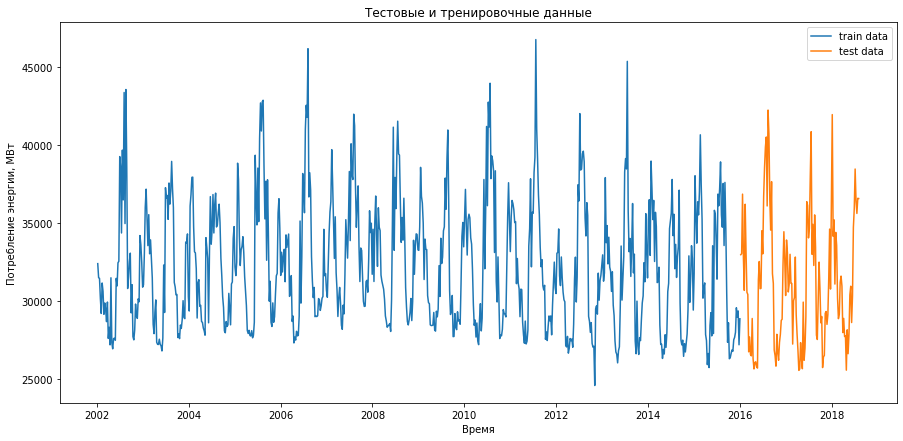

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Лучшие параметры: {'n_estimators': 1200, 'max_depth': 5}
Лучшая точность при данных параметрах: 0.545832497068695
ошибка mse :   0.5705696525981008 
ошибка mae  :   0.5751751819378355 
оценка R2 :   0.4595310583531338
ошибка градиентного бустинга MAPE :   7.117455952884025 %


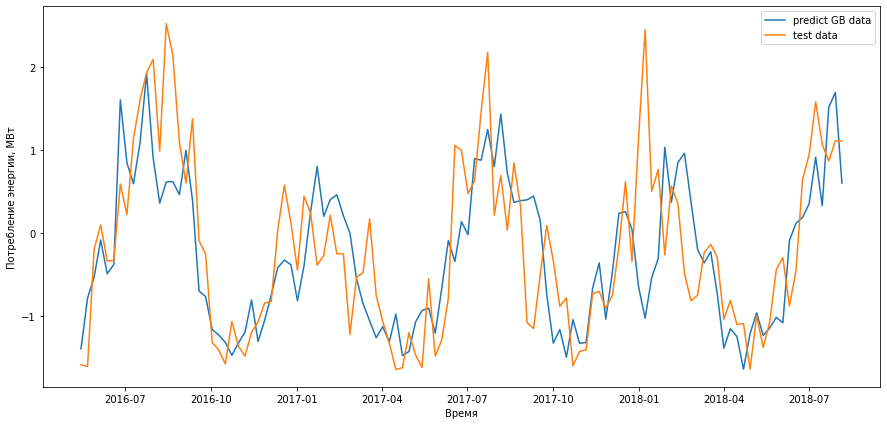

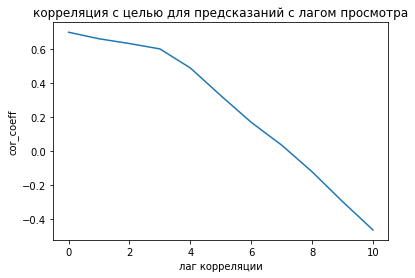

In [66]:
# подготовка признаков и окончательного датасета для предсказания 4-й точки от текущей (h = 4)
X_new, X, y, scl_x, scl_target,list_par = data_prepare(data_w, 'PJME_MW', h = 4, p = 14)
data_h4 = [X_new, X, y, scl_x, scl_target,list_par]

#строим модель предсказания 4-й точки от текущей (h = 4)
X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g = model(data_w, target = 'PJME_MW', title='Потребление энергии, МВт', 
      split_date='01-06-2016', X_new=X_new, X=X, y=y, scl_x=scl_x, scl_target=scl_target, n_iter_search=10, h=4, p=14)
model_h4 = [X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g]

3. Постройте модель предсказания 1-й точки от текущей (h = 1), используя результаты автокорреляционного анализа из предшествующих уроков.

Проверяем равенство размеров - Х: (851, 49), размер y: (851, 1)
Лучшие признаки по SelectKBest: ['PJME_MW', 'diff1_l', 'd_w7', 't12', 't11', 't2', 't1']
Лучшие признаки по процентному отбору: ['PJME_MW', 'diff1_l', 'd_w7', 't14', 't13', 't12', 't11', 't10', 't2', 't1']
Лучшие признаки по GradientBoostingRegressor: ['PJME_MW', 'diff1_l', 't11', 't8']
Список лучших параметров: [0, 33, 34, 12, 13, 21, 22, 23, 24, 25, 27]


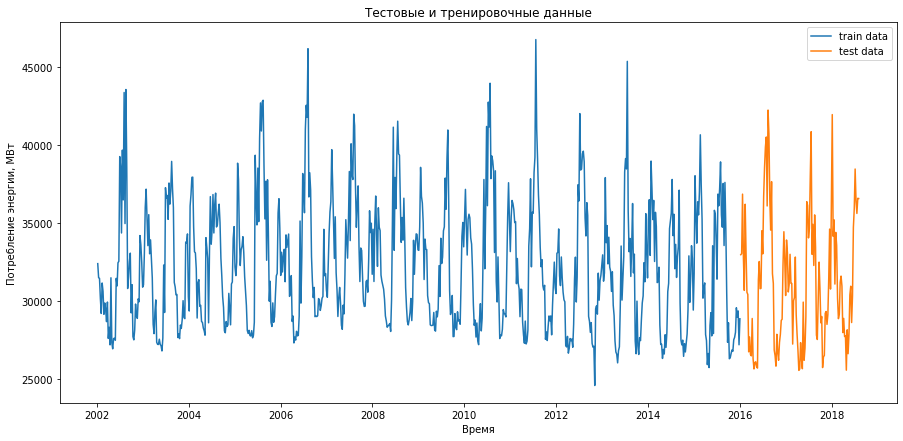

/usr/local/lib/python3.8/site-packages/sklearn/model_selection/_search.py:847: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  warnings.warn(


Лучшие параметры: {'n_estimators': 100, 'max_depth': 3}
Лучшая точность при данных параметрах: 0.6658329095251235
ошибка mse :   0.4196876802585772 
ошибка mae  :   0.5239147010270726 
оценка R2 :   0.6095630671358603
ошибка градиентного бустинга MAPE :   6.717466140029385 %


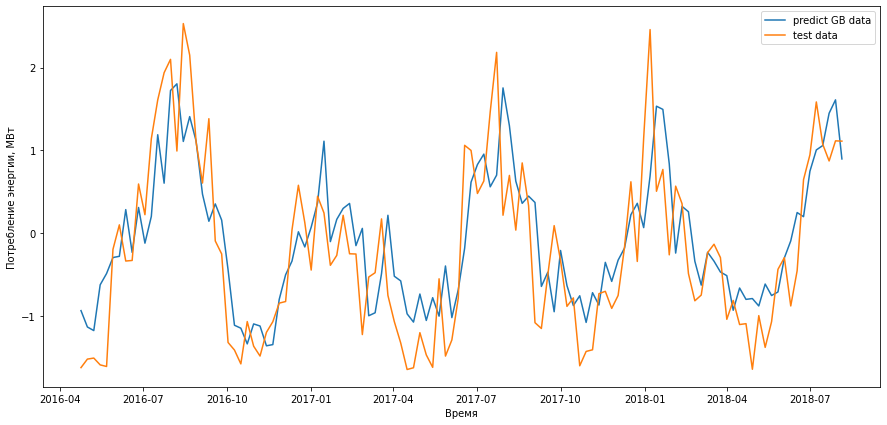

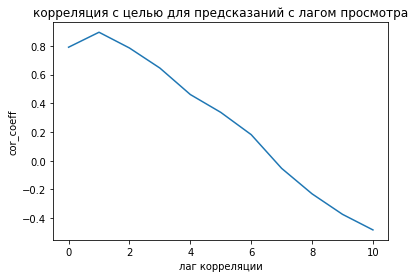

In [67]:
# подготовка признаков и окончательного датасета для предсказания 1-й точки от текущей (h = 1)
X_new, X, y, scl_x, scl_target, list_par = data_prepare(data_w, 'PJME_MW', h = 1, p = 14)
data_h1 = [X_new, X, y, scl_x, scl_target,list_par]
#строим модель предсказания 1-й точки от текущей (h = 1)
X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g = model(data_w, target = 'PJME_MW', title='Потребление энергии, МВт', 
      split_date='01-06-2016', X_new=X_new, X=X, y=y, scl_x=scl_x, scl_target=scl_target, n_iter_search=10, h=1, p=14)
model_h1 = [X_train, y_train, X_test, y_test, model_g_best, train, test, y_test_pred_g]

4. Примените авторекурсию и сравните результат в 4-й точке путем прямого моделирования и путем рекурсивного моделирования на длине выборки из 4-х точек. 

In [40]:
scl_target.scale_[0] , scl_target.mean_[0]

(3998.512300707125, 32122.647659485345)

In [41]:
scl_x.scale_[0] , scl_x.mean_[0]

(3999.1783859301036, 32111.61790392617)

In [ ]:
X_test_100 = X_test.copy()

In [78]:
cols_h1 = data_w.columns[data_h1[5]] 
print(f'список параметров вектора для модели с h = 1 \n  {list(cols_h1)}\n  номера: {data_h1[5]}')
cols_h4 = data_w.columns[data_h4[5]] 
print(f'список параметров вектора для модели с h = 4 \n  {list(cols_h4)}\n  номера: {data_h4[5]}') 

список параметров вектора для модели с h = 1 
  ['PJME_MW', 't2', 't1', 'diff1_l', 'd_w7', 't14', 't13', 't12', 't11', 't10', 't8']
  номера: [0, 33, 34, 12, 13, 21, 22, 23, 24, 25, 27]
список параметров вектора для модели с h = 4 
  ['PJME_MW', 'year', 'dayofyear', 'pca1', 'diff1_l', 'exp_0_03', 't13', 't12', 't11', 't10', 't9', 't8', 't7', 't6']
  номера: [0, 1, 5, 8, 12, 16, 22, 23, 24, 25, 26, 27, 28, 29]


### Тут я совсем не понял как рассчитываются "фейковые" следуюбщие точки признаков вектора, поэтому оставил как было в лекции

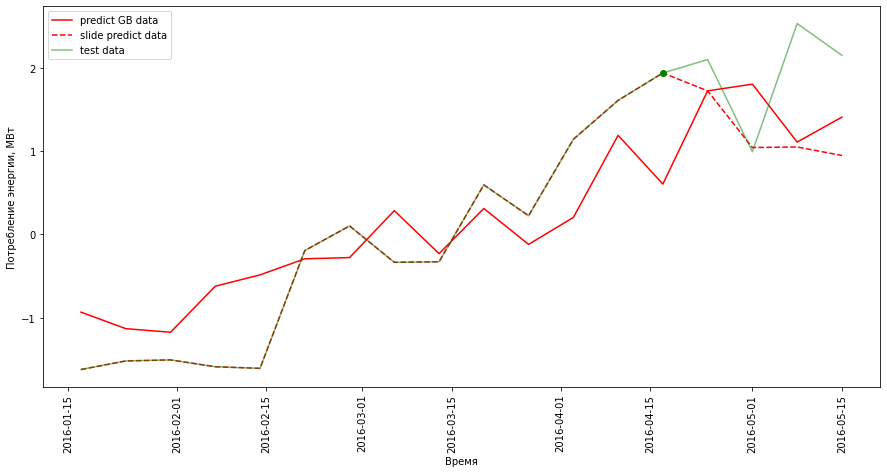

In [82]:

X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 4+p
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
   
    X_test_100[i+1,6] = X_test_100[i,6]*(1-0.06)+ 0.06 * X_test_100[i+1,0] 
    X_test_100[i+1,5] = X_test_100[i,5]*(1-0.05)+ 0.05 * X_test_100[i+1,0] 
    X_test_100[i+1,7] = X_test_100[i,7]*(1-0.07)+ 0.07 * X_test_100[i+1,0]
    X_test_100[i+1,8] = X_test_100[i,8]*(1-0.08)+ 0.08 * X_test_100[i+1,0]
    
    X_test_100[i+1,3] = np.mean(X_test_100[i-6:i+1,0]) 
   
    xy_i=(np.log((y_i))-scl_x.mean_[16])*scl_x.scale_[16]
    
    X_test_100[i+1,4] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,9] = X_test_100[i-6,0]
    X_test_100[i+1,10] = X_test_100[i-1,0]
        
    
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.xticks(rotation='90')
plt.legend()
plt.show()    

In [80]:
er_g = mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:N10]),y_pred = scl_target.inverse_transform( y_test_100[p:N10]))
print('ошибка градиентного бустинга MAPE :  ', er_g,'%')

ошибка градиентного бустинга MAPE :   7.522809434580988 %


Ошибка на 4-й точке путем прямого моделирования = 7.1%
Ошибка на на длине выборки из 4-х точек путем рекурсивного моделирования = 7.5%
таким образом рекурсивный метод дал нам точность меньше прямого на 0.4%:

5. Оцените рост ошибки прогнозирования рекурсивной модели в интервалах от 1-й до p-й, от p-й до 2*p-й, от 2*p-й до 3*p-й, .. .p*i-й до (i+1)*p -й,... ,от 9*p до 10*p-й точках (используйте осреденение точек, p - глубина истории, которую видим (в примере самая дальняя точка p=6))

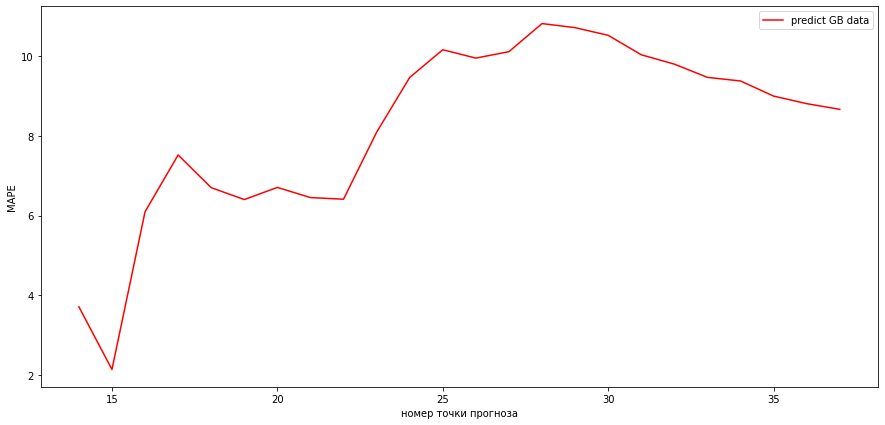

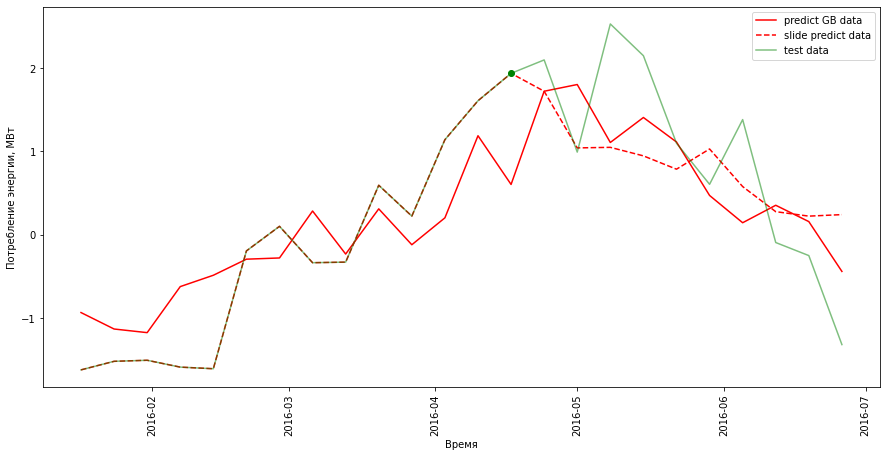

In [93]:
X_test_100 = X_test.copy()
y_test_100 = y_test.copy()
N10 = 10+p
error = []
for i in range(p,N10+p):
    y_test_100[i] = model_g_best.predict(X_test_100[i,:].reshape((1,X_test_100.shape[1])))
    # восстанавливаем не масштабированное значение ряда текущей точке  
    y_i=scl_target.inverse_transform(y_test_100[i:i+1]  )
                                     
    # заполняем вектор для прогноза следующей точки
    X_test_100[i+1,0] = (y_i-scl_x.mean_[0])/scl_x.scale_[0]
   
    X_test_100[i+1,6] = X_test_100[i,6]*(1-0.06)+ 0.06 * X_test_100[i+1,0] 
    X_test_100[i+1,5] = X_test_100[i,5]*(1-0.05)+ 0.05 * X_test_100[i+1,0] 
    X_test_100[i+1,7] = X_test_100[i,7]*(1-0.07)+ 0.07 * X_test_100[i+1,0]
    X_test_100[i+1,8] = X_test_100[i,8]*(1-0.08)+ 0.08 * X_test_100[i+1,0]
    
    X_test_100[i+1,3] = np.mean(X_test_100[i-6:i+1,0]) 
   
    xy_i=(np.log((y_i))-scl_x.mean_[16])*scl_x.scale_[16]
    
    X_test_100[i+1,4] = xy_i 
    # обновим историю значенний
    X_test_100[i+1,9] = X_test_100[i-6,0]
    X_test_100[i+1,10] = X_test_100[i-1,0]
    
    error.append([i, mean_absolute_percentage_error(y_true=scl_target.inverse_transform( y_test[p:i+1]),
                                          y_pred = scl_target.inverse_transform( y_test_100[p:i+1]))])
error = np.array(error) 
plt.figure( figsize=( 15, 7 ))
plt.xlabel('номер точки прогноза')
plt.ylabel('MAPE')
plt.plot(error[:,0],error[:,1], 'r',label='predict GB data' )
plt.legend()
plt.show()
    
plt.figure( figsize=( 15, 7 ))


plt.xlabel('Время')
plt.ylabel('Потребление энергии, МВт')
plt.plot(test.index[1:N10+1],y_test_pred_g[:N10], 'r',label='predict GB data' )
plt.plot(test.index[1:N10+1],y_test_100[:N10], '--r',label='slide predict data')
plt.plot(test.index[1:N10+1],y_test[:N10], 'g',label='test data', alpha=0.5)
plt.plot(test.index[p],y_test[p-1], 'og', alpha=1)
plt.xticks(rotation='90')
plt.legend()
plt.show()    

6. Сделайте вывод о том, как изменилось поведение ошибки предсказания ряда.

в целом ошибка возрастает с удалением от точки p